### TODO Recording:

- Go to https://colab.research.google.com
- Sign in with the account
- Show that you are using the GPU runtime
- Open up the folder icon on the left
- Upload the data.csv file to this folder

In [230]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

In [231]:
import tensorflow

print(tensorflow.__version__)

2.19.0


In [232]:
import keras

print(keras.__version__)

3.10.0


Loading the  data.
Dataset link-
https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

#### Gemini help (generate with AI):

Can you read the file available in this runtime and store it in a Pandas dataframe called financial_data?

In [237]:
financial_data = pd.read_csv("data.csv")

financial_data.sample(10)

,Sentence,Sentiment
3465,The Web-Marela application handles invitations...,neutral
2949,"Broker tips: RBS, Croda, Sage",positive
2688,$AAPL http://stks.co/1LDx Clearing this descen...,positive
4778,Export declined by 6 percent to 16.4 million l...,negative
2103,"The other seats would go to Edgar Edmonds , an...",neutral
2722,Revenues at the same time grew 14 percent to 4...,positive
3520,Long $PCLN,positive
5671,Net sales fell by 33 % from the third quarter ...,negative
1383,"Baird likes $TSLA - upgrades to outperform, li...",positive
2257,"Svyturys-Utenos Alus , which is controlled by ...",positive


Dataset info is obtained

In [234]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Null values are checked. Only one instance was found

In [235]:
financial_data.isnull().sum()

,0
Sentence,0
Sentiment,0


Duplicacy checked. None was found

Target balance is checked

In [238]:
financial_data["Sentiment"].value_counts()

,count
Sentiment,
neutral,3130
positive,1852
negative,860


Neutral class counts is highest

<Axes: xlabel='Sentiment', ylabel='count'>

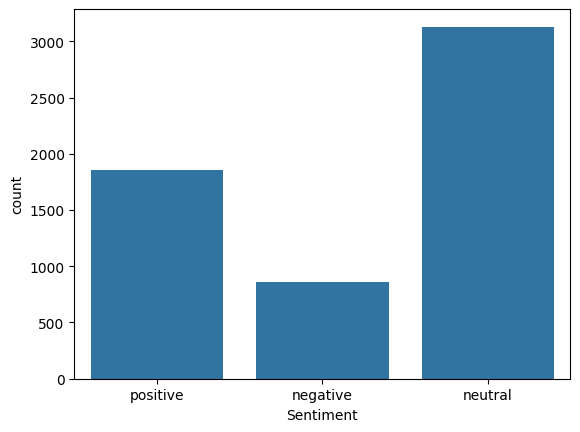

In [239]:
import seaborn as sns

sns.countplot(data = financial_data, x = "Sentiment")

#### Gemini help (generate with AI):

Can you interpret the bar chart of record counts in this notebook?

#### Gemini help (generate with AI):

I'd like to add a new column "WordCount" to the dataframe with a count of words in each sentence

In [240]:
financial_data["WordCount"] = financial_data["Sentence"].apply(lambda x: len(str(x).split(" ")))

financial_data[["Sentence", "WordCount"]].sample(10)

,Sentence,WordCount
236,The combined company had pro-forma net sales o...,28
312,It has80 branches in Finland with annual reven...,12
4090,Raute posted a net profit of 1.8 mln euro $ 2....,36
4942,UK WINNERS & LOSERS: Aviva And Friends Life Le...,12
1265,- Operating profit rose by 26.9 % to EUR 105.8...,15
2895,GyPSii service supports ten different language...,11
957,Under this agreement Biohit becomes a focus su...,20
2543,"`` After this purchase , Cramo will become the...",19
5798,$SPY $MITK fast 56pc dive http://stks.co/3ffN $$,7
434,Finnish Raisio ( Diagnostics ) is launching ne...,18


Mean word count is calculated for each class. Neutral class word count mean is slightly higher.

In [241]:
financial_data.groupby("Sentiment")["WordCount"].mean()

,WordCount
Sentiment,
negative,19.324419
neutral,22.146006
positive,19.956263


In [242]:
financial_data.groupby("Sentiment")["WordCount"].median()

,WordCount
Sentiment,
negative,17.0
neutral,21.0
positive,18.0


Word count distribution is checked with histogram and boxplot and word count mean and median seems to be very close for all the classes

<Axes: xlabel='WordCount', ylabel='Count'>

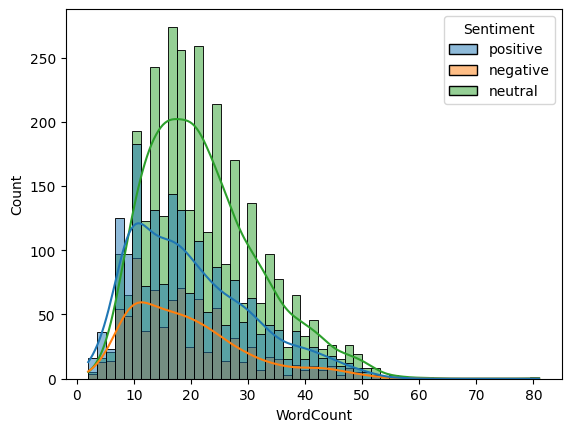

In [243]:
sns.histplot(data = financial_data, x = "WordCount", hue = "Sentiment", kde = True)

<Axes: ylabel='WordCount'>

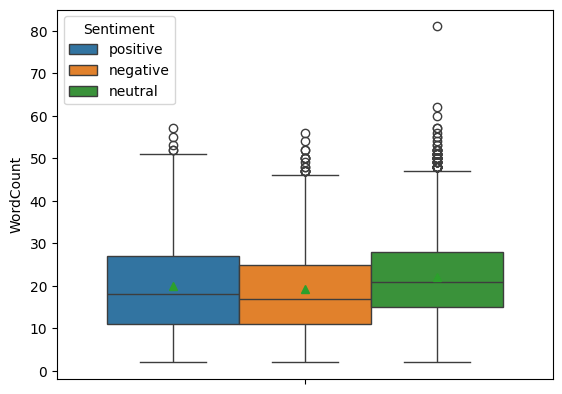

In [244]:
sns.boxplot(data = financial_data, y = "WordCount", hue = "Sentiment", showmeans = True)

Downloading stopwords and viewing all the stop words

In [245]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### ChatGPT

Why do you need to standardize text when working with natural language data?

In [145]:
import string

def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, r"\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, r"<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, r"\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, r"\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, r"\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

few texts are cleaned using the clean_text function..url is removed here. Stopwords are removed in all cases below

In [246]:
financial_data["Sentence"][5]

"$SPY wouldn't be surprised to see a green close"

In [247]:
custom_standardization(financial_data["Sentence"][5]).numpy()

b'spy  surprised see green close'

Digits , brackets, punctuations, stopwords are removed

In [251]:
financial_data["Sentence"][40]

'$TSLA recalling pretty much every single model X @cnnbrk got to short that even at work you jump in money trade'

In [252]:
custom_standardization(financial_data["Sentence"][40]).numpy()

b'tsla recalling pretty much every single model x got short even work jump money trade'

@ symbol is removed

Now we are cleaning messages by applying  custom standardization. This steps are for visualising word cloud and  not required for classification task

In [253]:
financial_data["CleanedText"] = financial_data["Sentence"].apply(custom_standardization)

financial_data

,Sentence,Sentiment,WordCount,CleanedText
0,The GeoSolutions technology will leverage Bene...,positive,32,tf.Tensor(b' geosolutions technology leverage ...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11,"tf.Tensor(b'esi lows bk real possibility', s..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,39,tf.Tensor(b' last quarter componenta net sal...
3,According to the Finnish-Russian Chamber of Co...,neutral,20,tf.Tensor(b'according finnishrussian chamber c...
4,The Swedish buyout firm has sold its remaining...,neutral,23,tf.Tensor(b' swedish buyout firm sold remainin...
...,...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,17,tf.Tensor(b'rising costs forced packaging prod...
5838,Nordic Walking was first used as a summer trai...,neutral,14,tf.Tensor(b'nordic walking first used summer t...
5839,"According shipping company Viking Line , the E...",neutral,16,tf.Tensor(b'according shipping company viking ...
5840,"In the building and home improvement trade , s...",neutral,18,tf.Tensor(b' building home improvement trade ...


Converting string in tensor form to plain text

In [254]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")  # Assuming utf-8 encoding

# Apply the function to the DataFrame column
financial_data["CleanedText"] = financial_data["CleanedText"].apply(tensor_to_string)

financial_data

,Sentence,Sentiment,WordCount,CleanedText
0,The GeoSolutions technology will leverage Bene...,positive,32,geosolutions technology leverage benefon gps...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11,esi lows bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,39,last quarter componenta net sales doubled p...
3,According to the Finnish-Russian Chamber of Co...,neutral,20,according finnishrussian chamber commerce maj...
4,The Swedish buyout firm has sold its remaining...,neutral,23,swedish buyout firm sold remaining percent s...
...,...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,17,rising costs forced packaging producer huhtama...
5838,Nordic Walking was first used as a summer trai...,neutral,14,nordic walking first used summer training meth...
5839,"According shipping company Viking Line , the E...",neutral,16,according shipping company viking line eu dec...
5840,"In the building and home improvement trade , s...",neutral,18,building home improvement trade sales decrea...


#### Gemini (generate with AI)

Can you display a word cloud visualization for only the positive sentences in the financial_data dataframe?

- Change the size to 1000 by 600

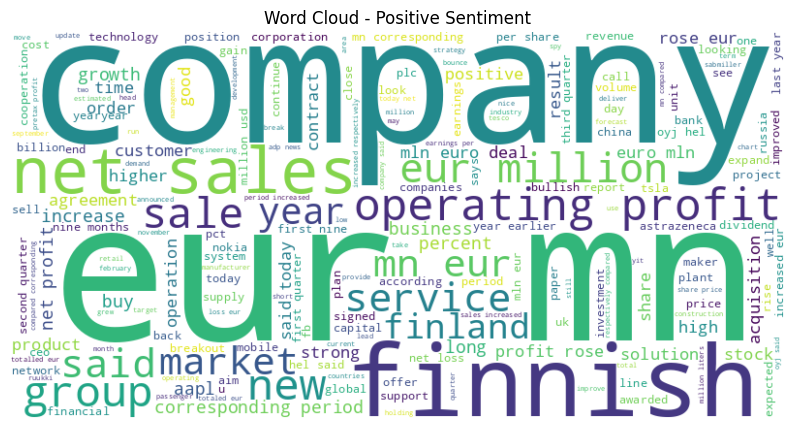

In [255]:
# Extract the text from positive sentiment sentences
positive_tweets = financial_data[financial_data["Sentiment"] == "positive"]["CleanedText"]

# Concatenate all the positive sentiment sentences into a single string
positive_text = " ".join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(positive_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

#### Gemini (generate with AI)

Can you do the same for negative sentences?

- Change the size to 1000 by 600

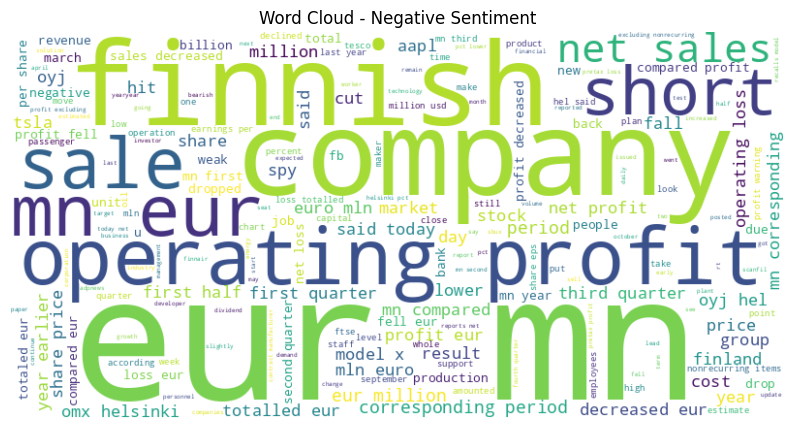

In [256]:
# Extract the text from negative sentiment tweets
negative_tweets = financial_data[financial_data["Sentiment"] == "negative"]["CleanedText"]

# Concatenate all the negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(negative_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment")
plt.show()

#### Gemini (generate with AI)

And now for nuetral sentences please

- Change the size to 1000 by 600

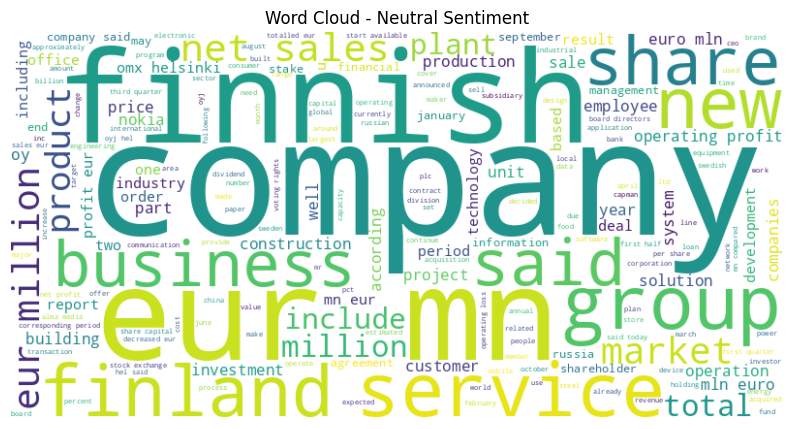

In [257]:
# Extract the text from neutral sentiment tweets
neutral_tweets = financial_data[financial_data["Sentiment"] == "neutral"]["CleanedText"]

# Concatenate all the neutral sentiment tweets into a single string
neutral_tweets = " ".join(neutral_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(neutral_tweets)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment")
plt.show()

Converting text labels to numeric form

In [259]:
financial_data["Sentiment"] = financial_data["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).infer_objects(copy=False)

financial_data.sample(10)

,Sentence,Sentiment,WordCount,CleanedText
4254,EMSA Deputy Chairman of the Board Juri Lember ...,0,35,emsa deputy chairman board juri lember told bn...
4939,Net sales for the financial year 2006 are expe...,0,30,net sales financial year expected amount opera...
3895,The airline 's share price closed down slightl...,0,22,airline share price closed slightly h...
168,"Adjusted for changes in the Group structure , ...",2,18,adjusted changes group structure division ne...
1188,"Following its strategy , Tikkurila has establi...",1,33,following strategy tikkurila established full...
229,$NUAN held up well after the big gains! Maybe ...,2,23,nuan held well big gains maybe finally move ...
813,Alma Media Corporation PRESS RELEASE March 25 ...,1,28,alma media corporation press release march ty...
5752,MD Henning Bahr of Stockmann Gruppen praises t...,2,22,md henning bahr stockmann gruppen praises tren...
5368,"F-Secure , a developer of security solutions a...",1,27,fsecure developer security solutions service ...
1572,"$FB trend, hits mid 110's and drops",0,7,fb trend hits mid drops


StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(financial_data, test_size = 0.2, stratify = financial_data["Sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["Sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((4205, 4), (468, 4), (1169, 4))

In [261]:
X_train["Sentiment"].value_counts()

,count
Sentiment,
1,2253
2,1333
0,619


In [262]:
X_val["Sentiment"].value_counts()

,count
Sentiment,
1,251
2,148
0,69


In [263]:
X_test["Sentiment"].value_counts()

,count
Sentiment,
1,626
2,371
0,172


#### Gemini (generate with AI)

How do I create TensorFlow datasets from the train, test, and validation data that I have? I'd like the datasets to be named raw_train_ds, raw_val_ds, and raw_test_ds


- Wait for the code to be generated and then follow up

Could you also set a batch size of 128 and shuffle the training data?

Creating Training and validation dataset from corresponding pandas dataframes

In [264]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["Sentence"].values, X_train["Sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["Sentence"].values, X_val["Sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["Sentence"].values, X_test["Sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(33, 4, 10)

# Count Vectorizer

Taking a simple example of small corpus, we are showing how count vectorizer works

#### ChatGPT

How do I convert text to numeric form in TensorFlow?



In [265]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "count",
)

In [266]:
# list of text documents
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

Next, we are  calling adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [267]:
count_vectorizer.adapt(text)

In [268]:
count_vectorizer.get_vocabulary()

['[UNK]',
 np.str_('is'),
 np.str_('malcolm'),
 np.str_('a'),
 np.str_('well'),
 np.str_('watching'),
 np.str_('too'),
 np.str_('teaching'),
 np.str_('teacher'),
 np.str_('quite'),
 np.str_('painter'),
 np.str_('loves'),
 np.str_('in'),
 np.str_('he'),
 np.str_('footballer'),
 np.str_('experienced'),
 np.str_('decent'),
 np.str_('dean'),
 np.str_('cricket'),
 np.str_('cooks'),
 np.str_('chris'),
 np.str_('an'),
 np.str_('amazing'),
 np.str_('also')]

Malcolm appearing twice in first doc.

In [269]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=int64, numpy=
array([[0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0],
       [0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0]])>

Next, we will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to count (Outputs a single int array per batch, of either vocab_size or max_tokens size,the int array contains a count of the number of times the token at that index appeared in the batch item.).

Note that you"re using the default split function, and the custom standardization function we defined above.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [270]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [271]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

Creating a function to see the result of using this layer to preprocess some data.

In [272]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

Extracting  a batch of tweets and labels from the dataset and displaying an instance with tweet , label and output of applying text vectorizer to the tweet

In [274]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_sentence, first_label = text_batch[0], label_batch[0]

print("Sentence: ", first_sentence)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_sentence, first_label))

Sentence:  tf.Tensor(b'Country : , Switzerland Sector : Pharmaceuticals Target : Synosia Therapeutics Holding AG Buyer : Biotie Therapies Corp Deal size in USD : 129.4 m Type : Corporate acquisition Financing : All-stock Status : Closed', shape=(), dtype=string)
Sentiment:  neutral
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [275]:
count_vectorizer.get_vocabulary()

['[UNK]',
 np.str_('eur'),
 np.str_('company'),
 np.str_('mn'),
 np.str_('eur mn'),
 np.str_('profit'),
 np.str_('finnish'),
 np.str_('sales'),
 np.str_('said'),
 np.str_('net'),
 np.str_('million'),
 np.str_('operating'),
 np.str_('mln'),
 np.str_('period'),
 np.str_('group'),
 np.str_('year'),
 np.str_('quarter'),
 np.str_('finland'),
 np.str_('share'),
 np.str_('oyj'),
 np.str_('new'),
 np.str_('first'),
 np.str_('net sales'),
 np.str_('business'),
 np.str_('operating profit'),
 np.str_('eur million'),
 np.str_('loss'),
 np.str_('shares'),
 np.str_('market'),
 np.str_('today'),
 np.str_('also'),
 np.str_('euro'),
 np.str_('compared'),
 np.str_('mn eur'),
 np.str_('services'),
 np.str_('corresponding'),
 np.str_('helsinki'),
 np.str_('operations'),
 np.str_('percent'),
 np.str_('corresponding period'),
 np.str_('bank'),
 np.str_('euro mln'),
 np.str_('products'),
 np.str_('net profit'),
 np.str_('mln euro'),
 np.str_('total'),
 np.str_('contract'),
 np.str_('per'),
 np.str_('hel'),
 

#### ChatGPT

I ran count_vectorizer.get_vocabulary() and the first token seems to be UNK - can you please explain what this is?

In [276]:
vocab_size =  len(count_vectorizer.get_vocabulary())

vocab_size

10000

Checking some instances of vocabulary

In [277]:
print("40   ---> ", count_vectorizer.get_vocabulary()[40])
print("80   ---> ", count_vectorizer.get_vocabulary()[80])
print("160  ---> ", count_vectorizer.get_vocabulary()[160])

40   --->  bank
80   --->  earlier
160  --->  data


Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

#### Gemini (generate AI)


Can you take the raw datasets we've created earlier and apply the vectorizer to them? Store the results in train_ds, val_ds, and test_ds

- Note that it will likely ask to prepare the dataset for training by adding caching and prefetching - say yes

- Or you can follow up

Now, let's prepare the datasets for training by adding caching and prefetching to improve performance.



In [278]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files. The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

.prefetch() The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [279]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

#### Gemini (generate AI)

Can you set up a dense neural network to perform sentiment analysis? I would like it to have 2 dense layers with 64 and 32 units, tanh activation and dropout of 10%

- Follow up

No embedding layer please just an input layer

- Fix the code as needed to match this code below

In [291]:
dnn_model = Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

Model is compiled and summary is obtained. As activation=softmax is not defined inside the final dense layer we have to set logits=True

from_logits:Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.

In [292]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

dnn_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Model is trained for 10 epochs

In [293]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4981 - loss: 1.0160 - val_accuracy: 0.5427 - val_loss: 0.9402
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5597 - loss: 0.9409 - val_accuracy: 0.5577 - val_loss: 0.9180
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6000 - loss: 0.8952 - val_accuracy: 0.5662 - val_loss: 0.9019
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6437 - loss: 0.8542 - val_accuracy: 0.6004 - val_loss: 0.8856
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6775 - loss: 0.8171 - val_accuracy: 0.6261 - val_loss: 0.8682
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7200 - loss: 0.7753 - val_accuracy: 0.6389 - val_loss: 0.8501
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7408 - loss: 0.7321 - val_accuracy: 0.6538 - val_loss: 0.8326
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7670 - loss: 0.6907 - val_accuracy: 0.6538 - val_loss

Loss and accuracy is evaluated on test data

In [294]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6684 - loss: 0.8075
Loss:  0.8149794340133667
Accuracy:  0.6706587076187134


Accuracy and Loss are plotted wrt epochs

In [295]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [296]:
history_dict

{'accuracy': [0.5186682343482971,
  0.5678953528404236,
  0.6057074666023254,
  0.6463733911514282,
  0.6803805232048035,
  0.7179548144340515,
  0.7400713562965393,
  0.7633769512176514,
  0.7778834700584412,
  0.7907253503799438],
 'loss': [0.9982854723930359,
  0.9326063990592957,
  0.888544499874115,
  0.8491795659065247,
  0.8104838132858276,
  0.7703506946563721,
  0.727549135684967,
  0.6834926009178162,
  0.6462181806564331,
  0.6082268357276917],
 'val_accuracy': [0.5427350401878357,
  0.557692289352417,
  0.5662392973899841,
  0.6004273295402527,
  0.6260683536529541,
  0.6388888955116272,
  0.6538461446762085,
  0.6538461446762085,
  0.6581196784973145,
  0.6602563858032227],
 'val_loss': [0.9401671290397644,
  0.9180364608764648,
  0.9019020795822144,
  0.8856034874916077,
  0.8681780099868774,
  0.8500586152076721,
  0.832578182220459,
  0.8157824277877808,
  0.8011732697486877,
  0.7879372835159302]}

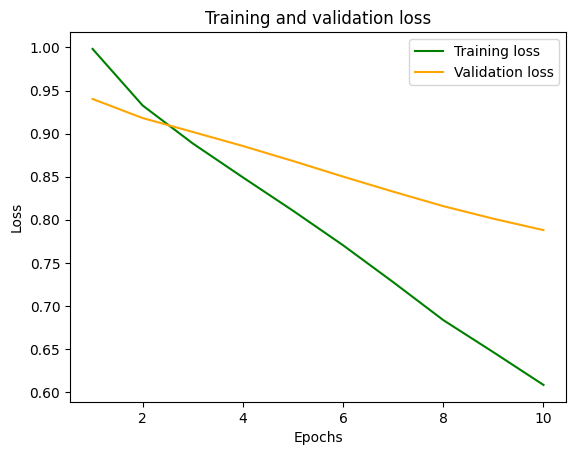

In [297]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

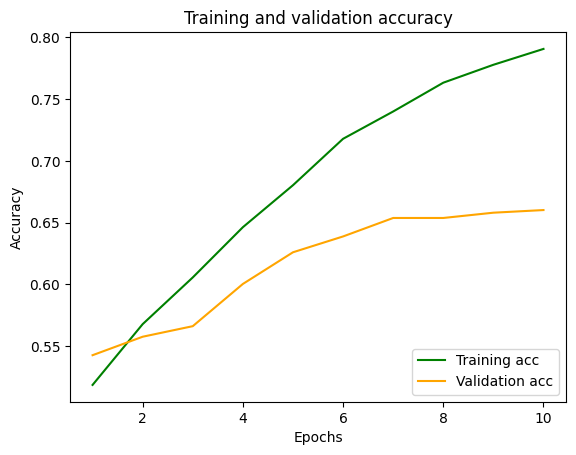

In [298]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In the training code above, we applied the TextVectorization layer to the dataset before feeding text to the model. If we want to make our  model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [299]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6684 - loss: 0.8075
0.6706587076187134


Cross verifying obtained metrics using sklearn. Recall is bit lower for Negative class(0.61)

In [300]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["Sentence"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["Sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.25      0.04      0.07       172
           1       0.67      0.89      0.77       626
           2       0.70      0.59      0.64       371

    accuracy                           0.67      1169
   macro avg       0.54      0.51      0.49      1169
weighted avg       0.62      0.67      0.62      1169



# TF-IDF Vectorizer

Now we are using TF-IDF Vectorizer instead of Count vectorizer

Taking a simple corpus

In [301]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [302]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [303]:
tfidf_vectorizer.adapt(text)

In [304]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 np.str_('is'),
 np.str_('malcolm'),
 np.str_('a'),
 np.str_('well'),
 np.str_('watching'),
 np.str_('too'),
 np.str_('teaching'),
 np.str_('teacher'),
 np.str_('quite'),
 np.str_('painter'),
 np.str_('loves'),
 np.str_('in'),
 np.str_('he'),
 np.str_('footballer'),
 np.str_('experienced'),
 np.str_('decent'),
 np.str_('dean'),
 np.str_('cricket'),
 np.str_('cooks'),
 np.str_('chris'),
 np.str_('an'),
 np.str_('amazing'),
 np.str_('also')]

tf idf scores can be seen for each word in vocabulary for each document

In [305]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

Now we are defining our tfidf vectorizer with parameters. Note here we are taking ngrams in range (1,2)

In [306]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

Checking the entire vocabulary

In [307]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 np.str_('eur'),
 np.str_('company'),
 np.str_('mn'),
 np.str_('eur mn'),
 np.str_('profit'),
 np.str_('finnish'),
 np.str_('sales'),
 np.str_('said'),
 np.str_('net'),
 np.str_('million'),
 np.str_('operating'),
 np.str_('mln'),
 np.str_('period'),
 np.str_('group'),
 np.str_('year'),
 np.str_('quarter'),
 np.str_('finland'),
 np.str_('share'),
 np.str_('oyj'),
 np.str_('new'),
 np.str_('first'),
 np.str_('net sales'),
 np.str_('business'),
 np.str_('operating profit'),
 np.str_('eur million'),
 np.str_('loss'),
 np.str_('shares'),
 np.str_('market'),
 np.str_('today'),
 np.str_('also'),
 np.str_('euro'),
 np.str_('compared'),
 np.str_('mn eur'),
 np.str_('services'),
 np.str_('corresponding'),
 np.str_('helsinki'),
 np.str_('operations'),
 np.str_('percent'),
 np.str_('corresponding period'),
 np.str_('bank'),
 np.str_('euro mln'),
 np.str_('products'),
 np.str_('net profit'),
 np.str_('mln euro'),
 np.str_('total'),
 np.str_('contract'),
 np.str_('per'),
 np.str_('hel'),
 

Creating a function to see the result of using this tfidf vectorizer layer to preprocess some data.

In [308]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [309]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [310]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Here same DNN is used but learning rate is decreased and model is trained for longer epochs(40)

In [311]:
dnn_model = Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3471 - loss: 1.2130 - val_accuracy: 0.3184 - val_loss: 1.2054
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3556 - loss: 1.1715 - val_accuracy: 0.3162 - val_loss: 1.1664
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3629 - loss: 1.1345 - val_accuracy: 0.3226 - val_loss: 1.1320
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3817 - loss: 1.1087 - val_accuracy: 0.3269 - val_loss: 1.1011
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4057 - loss: 1.0714 - val_accuracy: 0.3419 - val_loss: 1.0735
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4136 - loss: 1.0424 - val_accuracy: 0.3526 - val_loss: 1.0494
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4488 - loss: 1.0103 - val_accuracy: 0.3825 - val_loss: 1.0283
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4815 - loss: 0.9905 - val_accuracy: 0.4103 - val_loss

Performance on test data has decreased from previous model with count vectorizer.

In [312]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6077 - loss: 0.8723
Loss:  0.8762449026107788
Accuracy:  0.6090675592422485


Accuracy and Loss are plotted wrt epochs. Model is underfitting

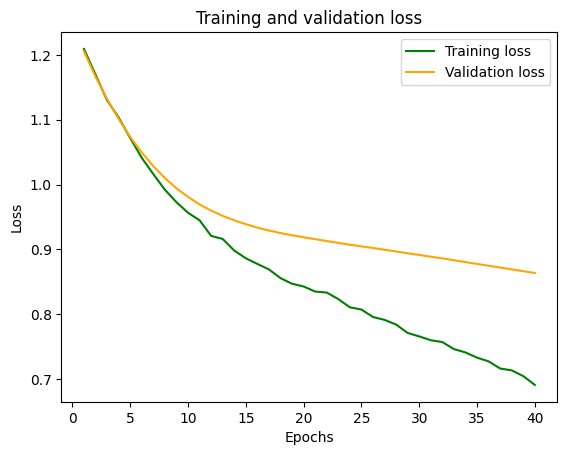

In [313]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

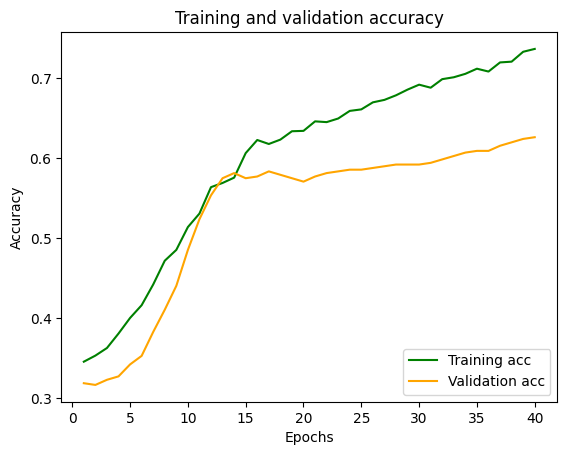

In [314]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [315]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6077 - loss: 0.8723
0.6090675592422485


# Embeddings

Defining a vectorized layer for training using Embedding layer. Steps will be repeated here too

"int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.

"output_sequence_length": Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape (batch_size, output_sequence_length) regardless of how many tokens resulted from the splitting step. Defaults to None.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

#### Gemini (generate with AI)

Can you set up the TextVectorization layer so that I can work with embeddings for sentiment analysis? I would like a vocabulary size of 10000 and have all sequences be of length 250. Please use the custom standardization that I had defined earlier.

Could you please specify the output mode as well? and I'll set up the embedding dimensions later

- Accept and fix the result as needed

In [316]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [317]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [318]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [319]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [320]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

We are using a callback list here

Early stopping — Interrupting training when the validation loss is no longer improving (and save the best model obtained during training).
ReduceLROnPlateau-Dynamically adjusting the value of certain parameters during training such as the learning rate optimizer.
Tensorboard-Logging training and validation metrics during training or visualizing representations learned by the model as they’re updated. (The Keras progress bar we always see in our terminal during training!)

Callbacks are passed to the during via the callback argument in the fit() method which takes a list of callbacks. Any number of callbacks can be passed to it.

The monitor argument in the EarlyStopping callback monitor’s the model’s validation accuracy and the patience argument interrupts training when the parameter passed to the monitor argument stops improving for more than the number (of epochs) passed to it (in this case 3).

Also, the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss has stopped improving. This has proven to be a very effective strategy to get out of local minima during training. The factor argument takes as input a float which is used to multipy the learning rate when triggered.Factor by which the learning rate will be reduced. new_lr = lr * factor.

In [325]:
callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 15,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 2,
        factor = 0.1,
    )
]

Neural network creation is started

The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.
Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
The last layer is densely connected with a triple output node as there are 3 labels.


#### A couple of practical confirmations:

- vectorize_layer.get_vocabulary() starts with the special tokens (padding '', then "[UNK]"), followed by your learned tokens. This is by design.
Keras

- When you wire your model, set the embedding size from the layer directly (no extra +1):
`Embedding(input_dim=vectorize_layer.vocabulary_size(), …)`—that’s what the TensorFlow guide shows. If you use padding, add mask_zero=True

- When you set `mask_zero=True`, the layer treats index 0 as a special padding value. It automatically generates a mask tensor (shape (batch, sequence_length)), with False wherever the input token is 0 and True elsewhere. This mask is passed to subsequent layers that support masking—ensuring that padded timesteps don’t participate in processing.

#### Embeddings
Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

#### GlobalAveragePooling1D

After passing through the embedding layer, you have a 3D tensor of shape (batch_size, sequence_length, embedding_dimension). GlobalAveragePooling1D compresses or reduces this 3D tensor into a 2D tensor. It does this by averaging over the sequence dimension (sequence_length), resulting in a 2D tensor of shape (batch_size, embedding_dimension). Essentially, it calculates the average of each embedding dimension across all words in the sequence.

Reduces Dimensionality: It simplifies the model by reducing the number of parameters, helping to mitigate overfitting.
Handles Variable Length Input: Useful in dealing with sentences of varying lengths, as it averages over the entire sequence length.
Captures Global Features: By averaging, it captures the essence of the entire input sequence, making it effective for tasks like document classification where the overall sentiment or theme is more important than the individual elements.


In [326]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Note that the validation accuracy stalls and the learning rate is reduced by a factor of 10 (multiplied by 0.1)

In [327]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.01),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 100,
    validation_data = val_ds,
    callbacks = callback_list
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.4594 - loss: 1.1195 - val_accuracy: 0.5363 - val_loss: 0.9832 - learning_rate: 0.0100
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5176 - loss: 1.0155 - val_accuracy: 0.5363 - val_loss: 0.9845 - learning_rate: 0.0100
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5131 - loss: 1.0035 - val_accuracy: 0.5363 - val_loss: 0.9843 - learning_rate: 0.0100
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5232 - loss: 0.9984 - val_accuracy: 0.5363 - val_loss: 0.9817 - learning_rate: 1.0000e-03
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5260 - loss: 0.9961 - val_accuracy: 0.5363 - val_loss: 0.9838 - learning_rate: 1.0000e-03
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5232 - loss: 0.9876 - val_accuracy: 0.5363 - val_loss: 0.9835 - learning_rate: 1.0000e-03
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5305 - loss: 0.

Peformance is not great

In [328]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5393 - loss: 0.9774
Loss:  0.9806807041168213
Accuracy:  0.5355004072189331


Accuracy and Loss are plotted wrt epochs. Model is overfitting

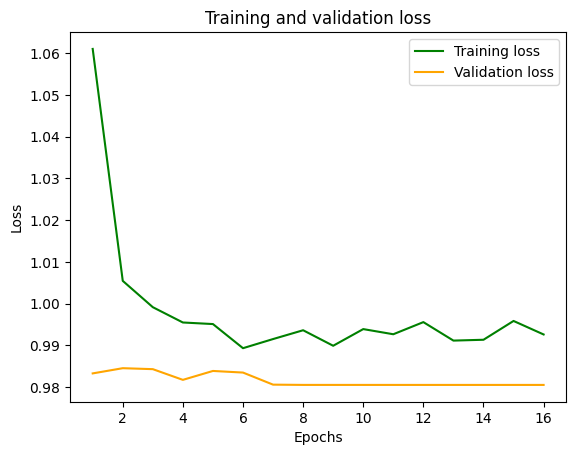

In [329]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

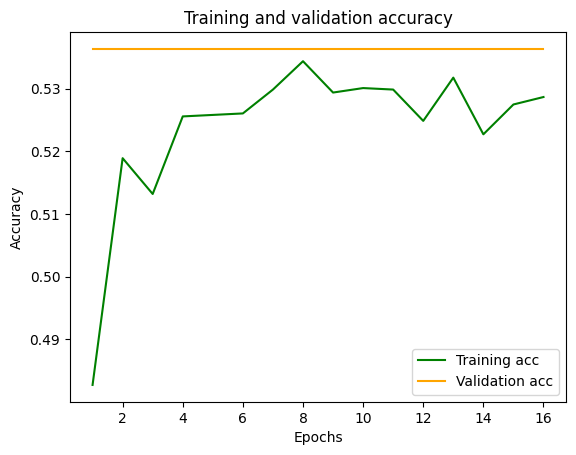

In [330]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

Now we will be training a more advanced neural network with RNNs. Steps will be repeated here too

We will train a simple RNN model. Note that final layer has softmax activation defined so  the setting is "from_logits = False".

In [331]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.5058 - loss: 0.9943 - val_accuracy: 0.5427 - val_loss: 0.9598 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5808 - loss: 0.8668 - val_accuracy: 0.6068 - val_loss: 0.9004 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7829 - loss: 0.6413 - val_accuracy: 0.6175 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8577 - loss: 0.3661 - val_accuracy: 0.5769 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9050 - loss: 0.2374 - val_accuracy: 0.6132 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9137 - loss: 0.1861 - val_accuracy: 0.6282 - val_loss: 0.9651 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9131 - loss: 0.1755 - val

In [332]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6157 - loss: 1.0342
Loss:  1.0424290895462036
Accuracy:  0.6193327903747559


Simple LSTM model is trained . Performance is marginally higher than our Count vectorizer +DNN model.

In [333]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4569 - loss: 1.0345 - val_accuracy: 0.5363 - val_loss: 0.9769 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5348 - loss: 0.9728 - val_accuracy: 0.5363 - val_loss: 0.9326 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6094 - loss: 0.8739 - val_accuracy: 0.6517 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7534 - loss: 0.6345 - val_accuracy: 0.6944 - val_loss: 0.7529 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8015 - loss: 0.4936 - val_accuracy: 0.6709 - val_loss: 0.7958 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8536 - loss: 0.3765 - val_accuracy: 0.6624 - val_loss: 0.8155 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8800 - loss: 0.2996 - val_acc

In [334]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6683 - loss: 0.9256
Loss:  0.947318434715271
Accuracy:  0.6561163663864136


Accuracy score and Losses are shown wrt epochs. Model overfitting after 3 epochs

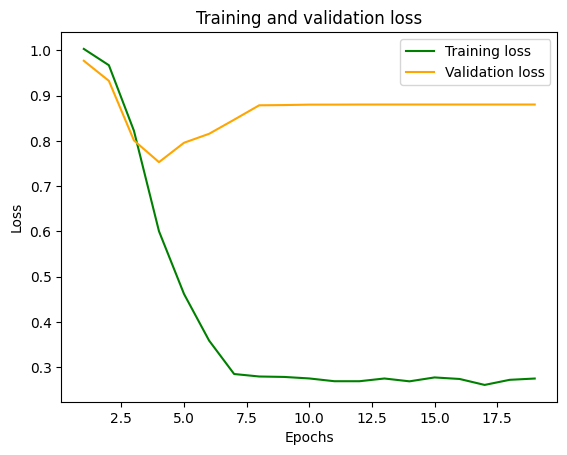

In [335]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

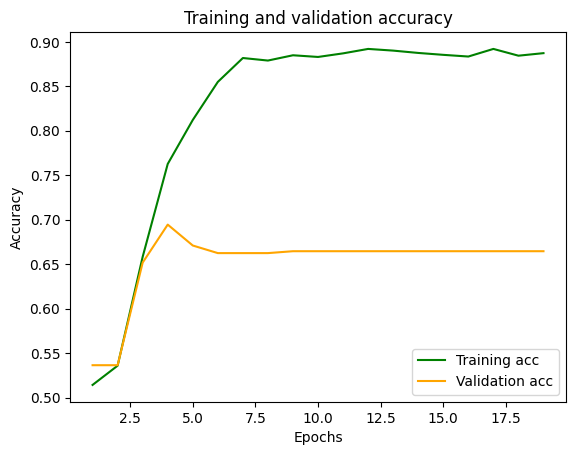

In [336]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [337]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6683 - loss: 0.9256
0.6561163663864136


We are doing inferencing on some examples and model predicting spam quite well.

In [341]:
financial_examples = [
    "The catastrophic market crash decimated my portfolio, leaving years of financial planning in ruins.",
    "After carefully reviewing the quarterly earnings report, the company's stock price saw a sharp increase.",
    "To secure the loan, the bank required collateral in the form of a home equity stake."
]

predictions = export_model.predict(tf.convert_to_tensor(financial_examples))

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[0.01746507, 0.97751105, 0.00502387],
       [0.02037402, 0.02119978, 0.9584262 ],
       [0.00277946, 0.9957397 , 0.0014808 ]], dtype=float32)

As we have already defined.."negative": 0, "neutral": 1, "positive": 2. So predictions makes sense

In [342]:
np.argmax(predictions, axis=1)

array([1, 2, 1])

Cross verifying metrics  with scikit-learn .
Recall for negative class seems to have improved . f1 score and accuracy improved for each class from our Count vectorizer+DNN model

In [344]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["Sentence"].values)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["Sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.32      0.28      0.30       172
           1       0.70      0.76      0.73       626
           2       0.72      0.65      0.68       371

    accuracy                           0.66      1169
   macro avg       0.58      0.57      0.57      1169
weighted avg       0.65      0.66      0.65      1169



Saving the trained model

In [345]:
lstm_model.save("sentiment_predictor.keras")

Loading the saved model and checking its performance

In [346]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6683 - loss: 0.9256
Loss:  0.947318434715271
Accuracy:  0.6561163663864136
